Bikram Rumba

MSCS-634-B01 Advanced Big Data and Data Mining

Clustering Analysis Using K-Means and K-Medoids Algorithms


In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Load the Wine Dataset
wine = load_wine()

# Create a DataFrame for easier exploration
df = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df['target'] = wine.target

print("=" * 60)
print("WINE DATASET EXPLORATION")
print("=" * 60)

# Display basic information
print("\nDataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nFeature Names:")
for i, feature in enumerate(wine.feature_names):
    print(f"{i+1}. {feature}")

print("\nTarget Classes:")
for i, name in enumerate(wine.target_names):
    print(f"Class {i}: {name}")

# Class distribution
print("\nClass Distribution:")
print(df['target'].value_counts().sort_index())

# Statistical summary
print("\nStatistical Summary of Features:")
print(df.describe())

# Split the dataset (80% training, 20% testing)
X = wine.data
y = wine.target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n" + "=" * 60)
print("DATASET SPLIT")
print("=" * 60)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")
# Check class distribution in train and test sets
print("\nTraining set class distribution:")
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_train)*100:.1f}%)")

print("\nTest set class distribution:")
unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_test)*100:.1f}%)")


# --- Standardize features (z-score) for clustering ---
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['target']).values)

# Quick sanity checks
print("\nStandardization check:")
print(" per-feature means (should be ~0):", np.round(X_scaled.mean(axis=0), 4))
print(" per-feature stds  (should be ~1):", np.round(X_scaled.std(axis=0, ddof=0), 4))

# Keep original labels for later evaluation
y_true = df['target'].values

print("\n Data loaded, explored, and standardized.")



WINE DATASET EXPLORATION

Dataset Shape: (178, 14)

First 5 rows:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04 

K-MEANS CLUSTERING RESULTS
Number of clusters (k): 3
Silhouette Score: 0.285
Adjusted Rand Index (ARI): 0.897


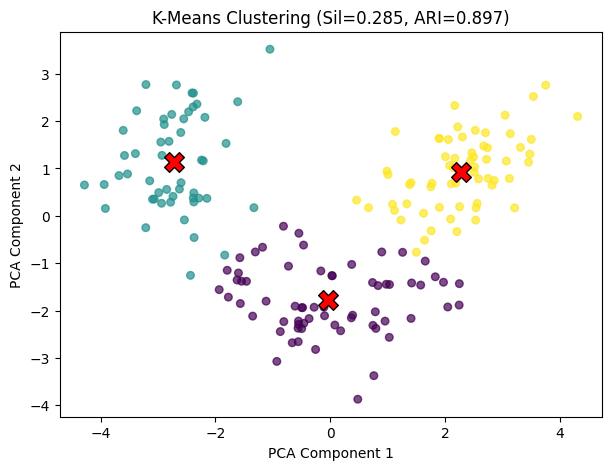

In [14]:
# ============================================
#  K-Means Clustering on the Wine Dataset
# ============================================

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Use k = 3 (since Wine dataset has 3 true classes)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)

# Fit and predict cluster labels
kmeans_labels = kmeans.fit_predict(X_scaled)

# Compute evaluation metrics
silhouette = silhouette_score(X_scaled, kmeans_labels)
ari = adjusted_rand_score(y_true, kmeans_labels)

print("=" * 60)
print("K-MEANS CLUSTERING RESULTS")
print("=" * 60)
print(f"Number of clusters (k): {k}")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Adjusted Rand Index (ARI): {ari:.3f}")
print("=" * 60)

# Optional: visualize in 2D using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
centroids_2d = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap='viridis', s=30, alpha=0.7)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], c='red', marker='X', s=200, edgecolor='black')
plt.title(f"K-Means Clustering (Sil={silhouette:.3f}, ARI={ari:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


K-MEDOIDS (PAM) RESULTS
Silhouette Score: 0.268
Adjusted Rand Index (ARI): 0.741


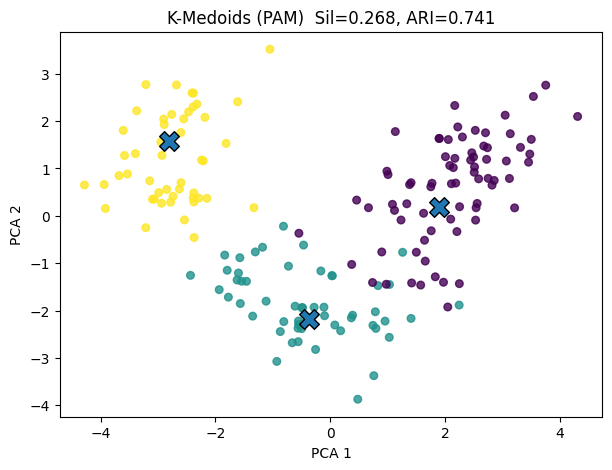

In [15]:
# ============================================
# STEP 3: K-Medoids (PAM) with NumPy only
# Uses X_scaled and y_true from Step 1
# ============================================

import numpy as np
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

rng = np.random.RandomState(42)

def pairwise_dist(X):
    # Euclidean distance matrix (n x n)
    diff = X[:, None, :] - X[None, :, :]
    return np.sqrt(np.sum(diff**2, axis=2))

def init_kpp(D, k, rng):
    # k-means++ style init but using medoids (indices)
    n = D.shape[0]
    medoids = []
    # first medoid
    medoids.append(rng.randint(n))
    # next medoids
    for _ in range(1, k):
        dist_to_nearest = np.min(D[:, medoids], axis=1)
        probs = dist_to_nearest**2
        probs = probs / probs.sum()
        medoids.append(rng.choice(n, p=probs))
    return np.array(sorted(set(medoids)))  # ensure unique

def assign_labels(D, medoids):
    # nearest medoid per point
    costs = D[:, medoids]                # (n x k)
    labels = np.argmin(costs, axis=1)    # cluster id 0..k-1
    return labels

def pam(D, k, rng, max_iter=100):
    # Build
    medoids = init_kpp(D, k, rng)
    # if duplicates slipped in, fill randomly
    while len(medoids) < k:
        cand = rng.randint(D.shape[0])
        if cand not in medoids:
            medoids = np.append(medoids, cand)
    medoids = np.array(medoids)

    labels = assign_labels(D, medoids)
    best_total = D[np.arange(D.shape[0]), medoids[labels]].sum()

    improved = True
    it = 0
    while improved and it < max_iter:
        improved = False
        it += 1
        # try all swaps: medoid m with non-medoid h
        non_medoids = np.setdiff1d(np.arange(D.shape[0]), medoids, assume_unique=True)
        for i_m, m in enumerate(medoids.copy()):
            for h in non_medoids:
                trial = medoids.copy()
                trial[i_m] = h
                trial_labels = assign_labels(D, trial)
                trial_total = D[np.arange(D.shape[0]), trial[trial_labels]].sum()
                if trial_total + 1e-9 < best_total:
                    medoids = trial
                    labels = trial_labels
                    best_total = trial_total
                    non_medoids = np.setdiff1d(np.arange(D.shape[0]), medoids, assume_unique=True)
                    improved = True
        # loop continues until no improving swap
    return np.array(sorted(medoids)), labels

# Build distance matrix once
D = pairwise_dist(X_scaled)

# Run PAM with k=3
k = 3
medoid_indices, kmed_labels = pam(D, k, rng)

# Metrics
silhouette_kmed = silhouette_score(X_scaled, kmed_labels)
ari_kmed = adjusted_rand_score(y_true, kmed_labels)

print("=" * 60)
print("K-MEDOIDS (PAM) RESULTS")
print("=" * 60)
print(f"Silhouette Score: {silhouette_kmed:.3f}")
print(f"Adjusted Rand Index (ARI): {ari_kmed:.3f}")

# 2D visualization via PCA (consistent with Step 2)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
medoids_2d = X_pca[medoid_indices]

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmed_labels, s=30, alpha=0.8)
plt.scatter(medoids_2d[:,0], medoids_2d[:,1], marker="X", s=200, edgecolor="black")
plt.title(f"K-Medoids (PAM)  Sil={silhouette_kmed:.3f}, ARI={ari_kmed:.3f}")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.show()


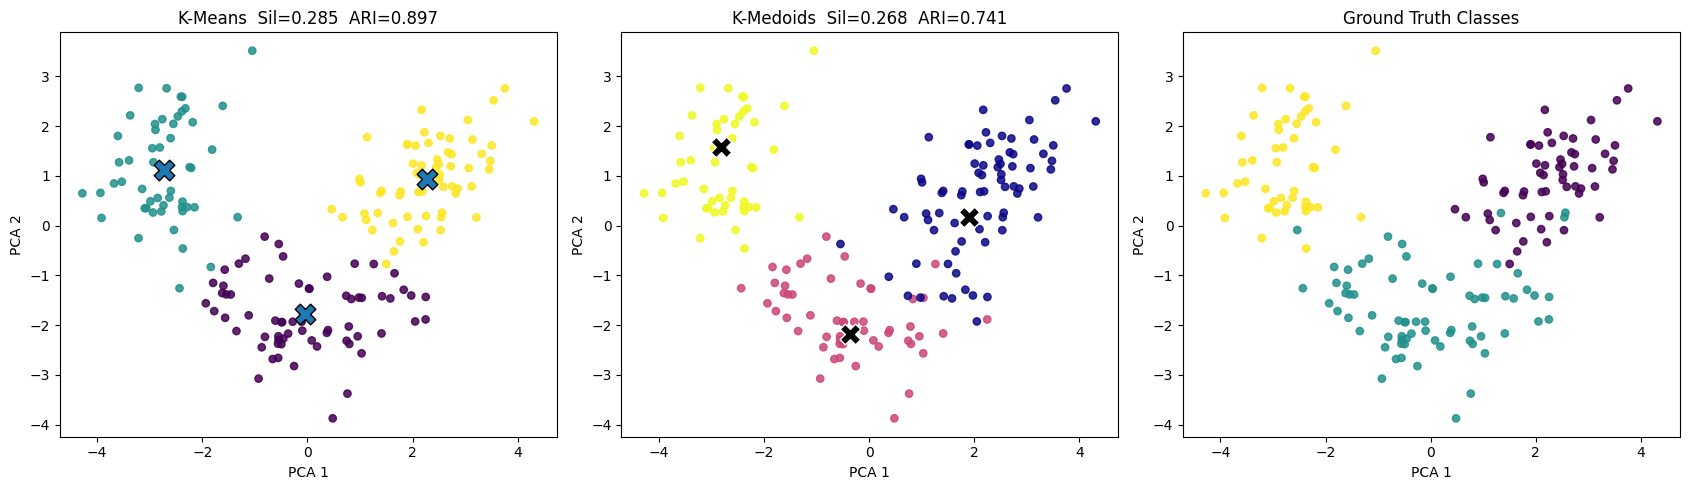

Comparison
----------
Silhouette: K-Means=0.285 | K-Medoids=0.268 -> K-Means
ARI:        K-Means=0.897 | K-Medoids=0.741 -> K-Means

When to prefer each:
- K-Means: faster, centroid-based; works well for roughly spherical clusters with similar variance.
- K-Medoids: robust to outliers and non-Gaussian noise; centers are actual points, helpful when prototypes must be real samples.


In [16]:
# ============================================
# STEP 4: Visualize and Compare K-Means vs K-Medoids
# ============================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.cluster import KMeans

# --- Helpers from Step 3 if not in memory ---
def _pairwise_dist(X):
    diff = X[:, None, :] - X[None, :, :]
    return np.sqrt(np.sum(diff**2, axis=2))

def _init_kpp(D, k, rng):
    n = D.shape[0]
    medoids = [rng.randint(n)]
    for _ in range(1, k):
        dist_to_nearest = np.min(D[:, medoids], axis=1)
        probs = dist_to_nearest**2
        probs = probs / probs.sum()
        medoids.append(rng.choice(n, p=probs))
    return np.array(sorted(set(medoids)))

def _assign_labels(D, medoids):
    return np.argmin(D[:, medoids], axis=1)

def _pam(D, k, rng, max_iter=100):
    medoids = _init_kpp(D, k, rng)
    while len(medoids) < k:
        cand = rng.randint(D.shape[0])
        if cand not in medoids:
            medoids = np.append(medoids, cand)
    labels = _assign_labels(D, medoids)
    best_total = D[np.arange(D.shape[0]), medoids[labels]].sum()
    it, improved = 0, True
    while improved and it < max_iter:
        improved, it = False, it+1
        non_medoids = np.setdiff1d(np.arange(D.shape[0]), medoids, assume_unique=True)
        for i_m, m in enumerate(medoids.copy()):
            for h in non_medoids:
                trial = medoids.copy(); trial[i_m] = h
                tlabels = _assign_labels(D, trial)
                ttotal = D[np.arange(D.shape[0]), trial[tlabels]].sum()
                if ttotal + 1e-9 < best_total:
                    medoids, labels, best_total = trial, tlabels, ttotal
                    non_medoids = np.setdiff1d(np.arange(D.shape[0]), medoids, assume_unique=True)
                    improved = True
    return np.array(sorted(medoids)), labels

# --- Ensure we have inputs from prior steps ---
assert 'X_scaled' in globals() and 'y_true' in globals(), "Run Step 1 first."

# K-Means (recompute if labels missing)
if 'kmeans_labels' not in globals() or 'kmeans' not in globals():
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=20).fit(X_scaled)
    kmeans_labels = kmeans.labels_
    kmeans_centers = kmeans.cluster_centers_
else:
    # ensure centers exist
    if 'kmeans_centers' not in globals():
        try:
            kmeans_centers = kmeans.cluster_centers_
        except:
            kmeans_centers = KMeans(n_clusters=3, random_state=42, n_init=20).fit(X_scaled).cluster_centers_

# K-Medoids (recompute if labels/medoids missing)
if 'kmed_labels' not in globals() or 'medoid_indices' not in globals():
    rng = np.random.RandomState(42)
    D = _pairwise_dist(X_scaled)
    medoid_indices, kmed_labels = _pam(D, 3, rng)

# --- Metrics
km_sil = silhouette_score(X_scaled, kmeans_labels)
km_ari = adjusted_rand_score(y_true, kmeans_labels)
kmed_sil = silhouette_score(X_scaled, kmed_labels)
kmed_ari = adjusted_rand_score(y_true, kmed_labels)

# --- 2D projection for plotting
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)
km_centers_2d = pca.transform(kmeans_centers)
kmed_medoids_2d = X_2d[medoid_indices]

# --- Plots: side-by-side + ground truth
fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# K-Means
axes[0].scatter(X_2d[:,0], X_2d[:,1], c=kmeans_labels, s=28, alpha=0.85)
axes[0].scatter(km_centers_2d[:,0], km_centers_2d[:,1], marker='X', s=220, edgecolor='black')
axes[0].set_title(f"K-Means  Sil={km_sil:.3f}  ARI={km_ari:.3f}")
axes[0].set_xlabel("PCA 1"); axes[0].set_ylabel("PCA 2")

# K-Medoids
axes[1].scatter(X_2d[:,0], X_2d[:,1], c=kmed_labels, s=28, alpha=0.85, cmap='plasma')
axes[1].scatter(kmed_medoids_2d[:,0], kmed_medoids_2d[:,1], marker='X', s=220, edgecolor='white', c='black')
axes[1].set_title(f"K-Medoids  Sil={kmed_sil:.3f}  ARI={kmed_ari:.3f}")
axes[1].set_xlabel("PCA 1"); axes[1].set_ylabel("PCA 2")

# Ground truth
axes[2].scatter(X_2d[:,0], X_2d[:,1], c=y_true, s=28, alpha=0.85)
axes[2].set_title("Ground Truth Classes")
axes[2].set_xlabel("PCA 1"); axes[2].set_ylabel("PCA 2")

plt.tight_layout()
plt.show()

# --- Brief comparison summary
print("Comparison")
print("----------")
print(f"Silhouette: K-Means={km_sil:.3f} | K-Medoids={kmed_sil:.3f} ->",
      "K-Means" if km_sil>kmed_sil else ("K-Medoids" if kmed_sil>km_sil else "Tie"))
print(f"ARI:        K-Means={km_ari:.3f} | K-Medoids={kmed_ari:.3f} ->",
      "K-Means" if km_ari>kmed_ari else ("K-Medoids" if kmed_ari>km_ari else "Tie"))

print("\nWhen to prefer each:")
print("- K-Means: faster, centroid-based; works well for roughly spherical clusters with similar variance.")
print("- K-Medoids: robust to outliers and non-Gaussian noise; centers are actual points, helpful when prototypes must be real samples.")
